In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text, num_show=1):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    if i == num_show:
      break
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/new/temp/textsum/model.seq2seq.attention.luong'
predictor = melt.Predictor(model_dir)

def inference(text, num_show=1):
  predict(predictor, text, num_show=num_show)

ENCODE_UNK 1
restore from /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-570000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-570000


import graph ok /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-570000.meta
restore ok /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-570000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5143, 5088, 7316, 532, 13, 691, 742, 805, 5143, 5088, 7316, 532, 13, 11810, 16506, 0, 0, 0, 0, 0] len: 20
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
0 [2893, 2893, 1] 蔬菜/蔬菜/<EOS> 0.00432990274721 -5.44221 -5.44221 [-2.2728653, -1.8742285, -1.2951164]


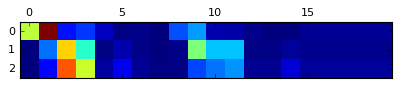

beam search using time(ms): 883.290052414
word_ids [214, 899, 322, 1866, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球/吗
你/去/打/篮球/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.104159266292 -2.26183 -2.26183 [-0.41239506, -0.022232225, -1.8272069]


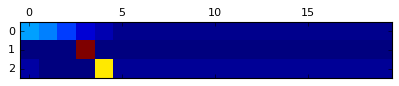

beam search using time(ms): 262.004137039
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0875768904983 -2.43524 -2.43524 [-0.43051293, -0.035734039, -1.9689912]


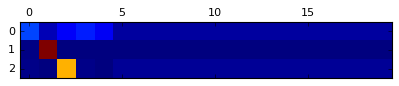

beam search using time(ms): 250.561952591
word_ids [1492, 210, 267, 244, 655, 8, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [267, 244, 655, 1] 周/华/健/<EOS> 0.181160331333 -1.70837 -1.70837 [-0.33001095, -0.20691988, -0.039185714, -1.1322563]


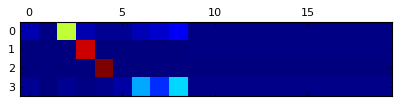

beam search using time(ms): 267.988920212
word_ids [25394, 84, 2743, 19, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [19, 807, 752, 1] 高/晓/松/<EOS> 0.0109070508399 -4.51835 -4.51835 [-3.1569114, -0.51325762, -0.036066864, -0.81211019]


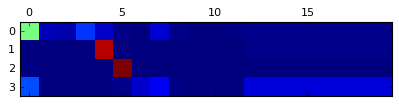

beam search using time(ms): 236.618995667
word_ids [60, 811, 2742, 235, 949, 3383, 60, 811, 2742, 2841, 1679, 57, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
0 [60, 811, 2742, 2841, 1679, 1] 王/凯/整容/前后/对比/<EOS> 0.0686005447399 -2.67945 -2.67945 [-0.34196144, -0.0196786, -0.7397005, -0.3333368, -0.68587285, -0.55890459]


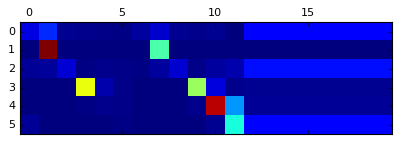

beam search using time(ms): 246.517896652
word_ids [6423, 1083, 5327, 226, 24332, 668, 668, 163, 13, 4073, 62, 107, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
0 [4073, 62, 107, 1] 吊带/黑/丝/<EOS> 0.0233786884001 -3.75593 -3.75593 [-2.8715441, -0.16268726, -0.017445099, -0.70425397]


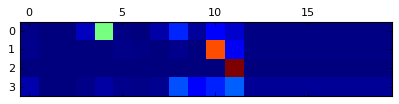

beam search using time(ms): 264.107942581
word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [1672, 485, 3243, 1] 彭/于/晏/<EOS> 0.0178347910571 -4.0266 -4.0266 [-1.0766745, -0.0029937471, -0.04234115, -2.9045949]


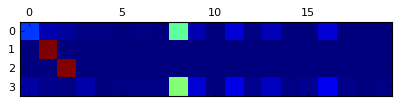

beam search using time(ms): 240.546941757
word_ids [37, 14356, 7, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 14356, 1] 美女/劈叉/<EOS> 0.00972341130031 -4.63322 -4.63322 [-0.69979328, -2.9652126, -0.9682126]


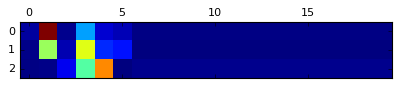

beam search using time(ms): 256.55579567
word_ids [1817, 7, 1252, 228, 7, 4006, 228, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
》/ /卫生/间/ /洗手/间/ 
》/ /卫生/间/ /洗手/间/ 
0 [1252, 228, 4006, 228, 1] 卫生/间/洗手/间/<EOS> 0.0469662730711 -3.05833 -3.05833 [-0.79995131, -0.0034711843, -1.0542496, -0.20547083, -0.99518245]


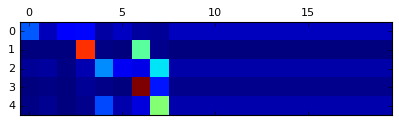

beam search using time(ms): 271.140813828
word_ids [2234, 7, 3885, 4193, 828, 146, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
iphone/ /6s/耐克/主题/手机/壁纸
iphone/ /6s/耐克/主题/手机/壁纸
0 [3885, 146, 30, 1] 6s/手机/壁纸/<EOS> 0.00569746925866 -5.16773 -5.16773 [-1.6971345, -1.5993254, -0.42732412, -1.4439495]


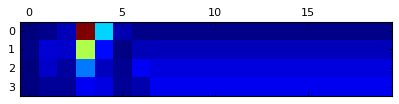

beam search using time(ms): 238.709926605


In [8]:
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
predict(predictor, '你去打篮球吗')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('年少不懂高晓松,读懂已不再少年')
inference('王凯整容了吗_王凯整容前后对比照片')
inference('【贴图】韩敏英--性感小吊带黑丝')
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看')
inference('美女劈叉 鼻血狂喷')
inference('》 卫生间 洗手间 ')
inference('iphone 6s耐克主题手机壁纸')

word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
0 [1298, 426, 775, 448, 1] 赵丽/颖/古装/剧照/<EOS> 0.0883494330135 -2.42646 -2.42646 [-0.22113644, -0.0014447261, -0.38309664, -1.5140984, -0.30667928]


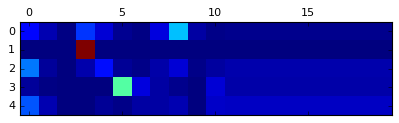

beam search using time(ms): 244.583129883


In [9]:
inference('蜀山战纪赵丽颖古装剧照(12张) ')

word_ids [323, 56, 758, 45, 301, 9147, 1733, 410, 570, 1100, 8, 6091, 1817, 0, 0, 0, 0, 0, 0, 0] len: 20
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
0 [45, 301, 6091, 1] 简/笔画/小鱼/<EOS> 0.0102183369344 -4.58357 -4.58357 [-2.8634562, -0.026307762, -1.3067207, -0.38708669]


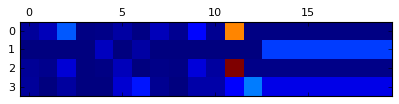

beam search using time(ms): 245.172023773


In [10]:
inference('幼儿园动物简笔画教案《两条漂亮的小鱼》')

word_ids [334, 595, 85, 1034, 11, 5593, 121, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
第/六/感/美甲/美/睫/纹/秀
第/六/感/美甲/美/睫/纹/秀
0 [1034, 1] 美甲/<EOS> 0.0236285381335 -3.7453 -3.7453 [-0.32893643, -3.4163637]


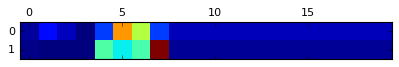

beam search using time(ms): 251.005172729


In [11]:
inference('第六感美甲美睫纹秀')

word_ids [4305, 5762, 3136, 5697, 2060, 389, 1961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
2013/春夏/男装/米兰/时装/秀/9
2013/春夏/男装/米兰/时装/秀/9
0 [2060, 389, 1] 时装/秀/<EOS> 0.0787252231479 -2.54179 -2.54179 [-0.92097747, -0.0055489084, -1.6152654]


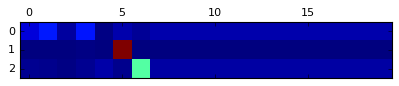

beam search using time(ms): 254.076004028


In [12]:
inference('2013春夏男装米兰时装秀9')

word_ids [772, 7630, 67, 89652, 8, 19841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
关于/房价/最/透彻/的/解读
关于/房价/最/透彻/的/解读
0 [7630, 1] 房价/<EOS> 0.00432589091076 -5.44314 -5.44314 [-3.1207871, -2.3223498]


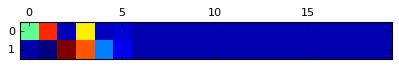

beam search using time(ms): 244.937896729


In [13]:
inference('关于房价最透彻的解读')

word_ids [4667, 630, 7902, 51, 1297, 10515, 4961, 7170, 16504, 3467, 25032, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
0 [10515, 4961, 1] 职称/制度/<EOS> 0.00880876964189 -4.73201 -4.73201 [-2.9755614, -1.3653612, -0.39108515]


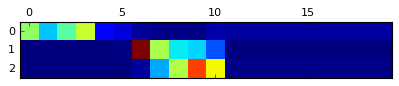

beam search using time(ms): 257.694959641


In [14]:
inference('辽宁省中小学教师职称制度改革实施方案出台')

word_ids [4470, 452, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
骷髅/情侣/纹身
骷髅/情侣/纹身
0 [4470, 208, 1] 骷髅/纹身/<EOS> 0.0231522537964 -3.76566 -3.76566 [-1.723659, -1.1483455, -0.89365852]


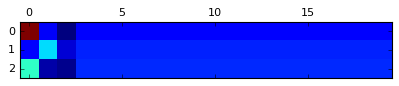

beam search using time(ms): 243.381977081


In [15]:
inference('骷髅情侣纹身')

word_ids [42999, 869, 1474, 363, 8, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0802099642999 -2.52311 -2.52311 [-0.54328758, -0.0065280045, -0.0030339186, -1.970258]


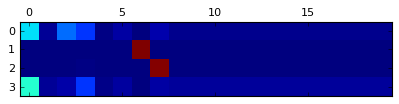

酷似/朴/姬/兰/的/刘/亦/菲
1 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.0279690477322 -3.57666 -3.57666 [-0.54328758, -0.0065280045, -0.0030339186, -2.5402844, -0.48352277]


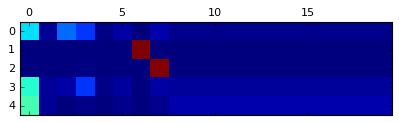

beam search using time(ms): 332.65709877


In [16]:
inference('酷似朴姬兰的刘亦菲', 2)

word_ids [42999, 164, 926, 649, 8, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0552786733131 -2.89537 -2.89537 [-1.0477644, -0.019401541, -0.0048149354, -1.823387]


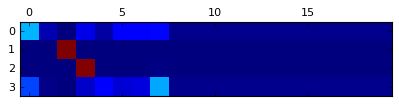

酷似/刘/亦/菲/的/朴/姬/兰
1 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.02195429815 -3.81879 -3.81879 [-2.3623605, -0.10495407, -0.35354298, -0.9979347]


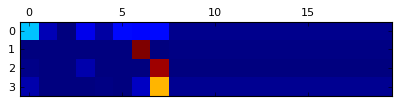

酷似/刘/亦/菲/的/朴/姬/兰
2 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.0196000609168 -3.93222 -3.93222 [-1.0477644, -0.019401541, -0.0048149354, -2.5088835, -0.35135826]


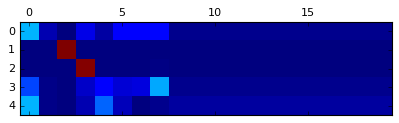

酷似/刘/亦/菲/的/朴/姬/兰
3 [20, 1] <UNK>/<EOS> 0.0166639718594 -4.09451 -4.09451 [-3.6104484, -0.48405769]


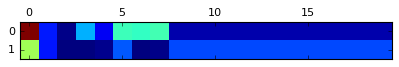

酷似/刘/亦/菲/的/朴/姬/兰
4 [869, 1474, 363, 363, 1] 朴/姬/兰/兰/<EOS> 0.00562791882099 -5.18002 -5.18002 [-2.3623605, -0.10495407, -0.35354298, -1.5326971, -0.82646108]


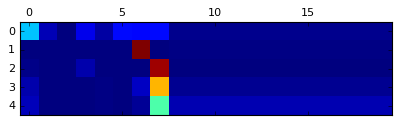

beam search using time(ms): 561.158895493


In [17]:
inference('酷似刘亦菲的朴姬兰', 5)

word_ids [97, 80, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
我/爱/打/篮球
我/爱/打/篮球
0 [322, 1866, 1] 打/篮球/<EOS> 0.0554070583426 -2.89305 -2.89305 [-1.0570457, -0.012074003, -1.8239287]


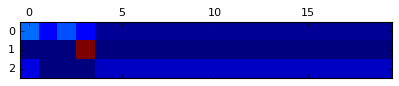

beam search using time(ms): 239.742040634


In [18]:
inference('我爱打篮球')

word_ids [322, 1866, 181, 84, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/好/不/好
打/篮球/好/不/好
0 [322, 1866, 1] 打/篮球/<EOS> 0.0655997547898 -2.72418 -2.72418 [-0.75744289, -0.018975165, -1.9477654]


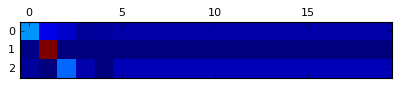

beam search using time(ms): 248.833179474


In [19]:
inference('打篮球好不好')

word_ids [27135, 7, 1614, 6577, 8, 157, 10898, 21077, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
0 [20, 1] <UNK>/<EOS> 0.0116228255634 -4.45478 -4.45478 [-4.0007448, -0.45403981]


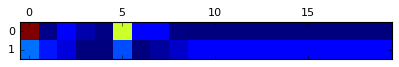

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
1 [157, 10898, 1] 南/美洲/<EOS> 0.00653887467587 -5.02999 -5.02999 [-3.0523164, -0.034006257, -1.9436673]


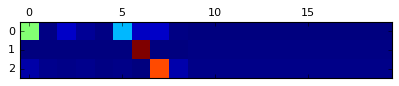

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
2 [9525, 1] 夏威夷/<EOS> 0.00512122255967 -5.27436 -5.27436 [-3.5078542, -1.7665079]


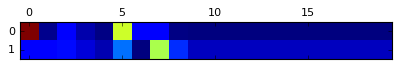

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
3 [10835, 1] 南非/<EOS> 0.00229703391827 -6.07614 -6.07614 [-3.5590818, -2.5170546]


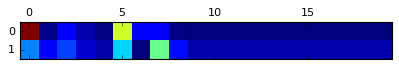

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
4 [5974, 1] 澳大利亚/<EOS> 0.0021412793226 -6.14635 -6.14635 [-3.3215234, -2.8248286]


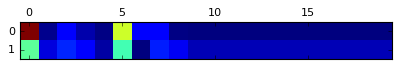

beam search using time(ms): 537.289142609


In [20]:
inference('厄瓜多尔 美丽神秘的南美洲国度 ', 5)

word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [1672, 485, 3243, 1] 彭/于/晏/<EOS> 0.0178347740486 -4.02661 -4.02661 [-1.0766758, -0.0029937471, -0.042341262, -2.9045944]


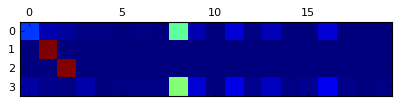

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
1 [1672, 485, 3243, 16400, 670, 1] 彭/于/晏/寒战/2/<EOS> 0.0175578528888 -4.04225 -4.04225 [-1.0766758, -0.0029937471, -0.042341262, -1.5178185, -0.64245409, -0.75997061]


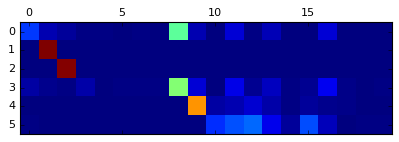

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
2 [16400, 670, 1] 寒战/2/<EOS> 0.0132133059132 -4.32653 -4.32653 [-2.4201665, -0.22321336, -1.6831511]


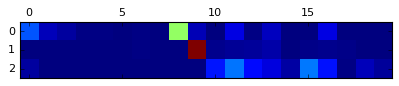

beam search using time(ms): 412.316083908


In [21]:
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看', 3)